# Raster data access 说明文档


Geogenius 提供了多种方式通过数据的id获取数据，现在可提供的类包括 CatalogImage，OBSImage,他们都拓展自RDAImage这个类。目前返回的是S3Tiff格式的数据。

## 1.Catalog Images

CatalogImage只有一个必填参数(cat-id),还有其它可选参数（*待实现*）

In [10]:
from geogeniustools.images.catalog_image import CatalogImage

In [11]:
img = CatalogImage(cat_id="164aa4e9-e271-4c8f-b14f-0fc9e766717a")

值得一提的是，上面的操作不会马上调用瓦片服务，img代表了存储在服务器中的一个数据对象，它具有丰富的属性信息，包括shape,bounds,metadata,affine,ntiles,proj

In [124]:
print(img.metadata)  #返回数据的元数据信息

print(img.shape) #获取图的形状特征，返回波段和影像长宽信息

print(img.affine)   #仿射矩阵

print(img.ntiles)  

print(img.proj)  #返回数据的投影坐标系

print(img.bounds) #获取数据对应坐标系下的四至坐标

{'image': {'imageWidth': 24944, 'imageHeight': 20174, 'numBands': 4, 'minX': 0, 'minY': 0, 'maxX': 24943, 'maxY': 20173, 'dataType': 'uint8', 'tileXSize': 512, 'tileYSize': 512, 'numXTiles': 49, 'numYTiles': 40, 'minTileX': 0, 'minTileY': 0, 'maxTileX': 48, 'maxTileY': 39}, 'georef': {'spatialReferenceSystemCode': 'EPSG:4326', 'scaleX': 1.9177827938623557e-05, 'shearX': 0.0, 'translateX': 116.51542136641909, 'shearY': 0.0, 'scaleY': -1.9177827938623557e-05, 'translateY': 36.56168748747642}}
(4, 164, 164)
| 0.00, 0.00, 116.71|
| 0.00,-0.00, 36.37|
| 0.00, 0.00, 1.00|
1
EPSG:4326
(116.70719964580533, 36.36676404430825, 116.71034480958726, 36.369909208090185)


img数据对象存储了地理空间信息，并且支持Python地理空间接口。你能很简单的获取对象的边界并且对它进行重投影，或者将边界转换为geometry对象。

In [122]:
from shapely.geometry import shape

print(img.__geo_interface__) # a geojson-like Python dictionary
print(shape(img).area) # shape() returns a Shapely object for geometry operations

{'type': 'Polygon', 'coordinates': (((116.71034480958726, 36.369909208090185), (116.71034480958726, 36.36676404430825), (116.70719964580533, 36.36676404430825), (116.70719964580533, 36.369909208090185), (116.71034480958726, 36.369909208090185)),)}
9.892055215165439e-06


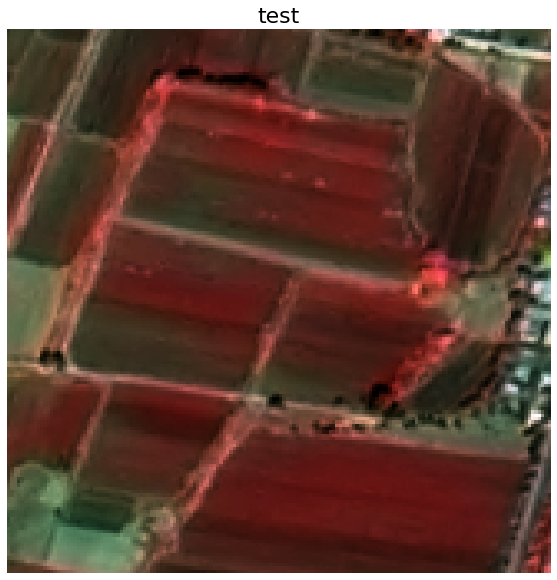

In [59]:
img.plot(bands=[3,2,1],title="test")

In [125]:
#img = CatalogImage('164aa4e9-e271-4c8f-b14f-0fc9e766717a', bbox=[116.7072, 36.366, 116.710, 36.3699])

## 2.定义AOIs

除了在catlogImage类中传入bbox参数（暂不支持）外，还可以通过创建geometry类型的对象作为边界对影像数据进一步的裁剪，获得感兴趣区域。下面的例子中创建了一个方形的box对象，裁剪了刚刚获取的img数据并进行了展示。

In [166]:
from shapely.geometry import box

In [167]:
bbox=box(116.7072, 36.367, 116.710, 36.3699)

In [168]:
aoi=img[bbox]

In [169]:
print(aoi)

dask.array<getitem, shape=(4, 152, 146), dtype=uint8, chunksize=(4, 152, 146)>


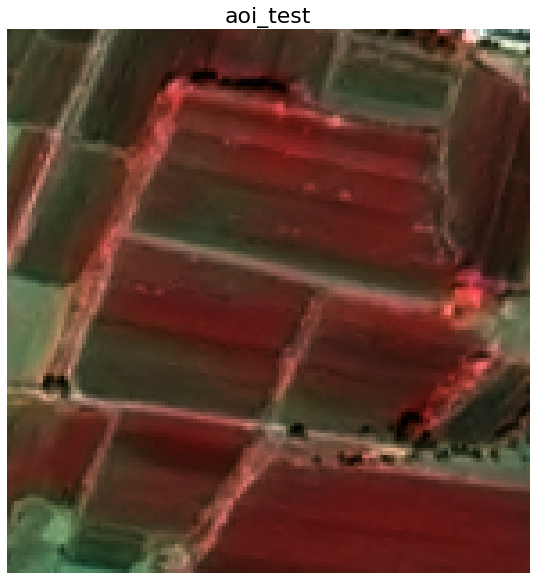

In [170]:
aoi.plot(bands=[3,2,1],title="aoi_test")

因为img对象将数据存储为Numpy Array 的格式，他们还支持基础的数组切片方法来进行aoi区域的裁剪。

(4, 40, 60)


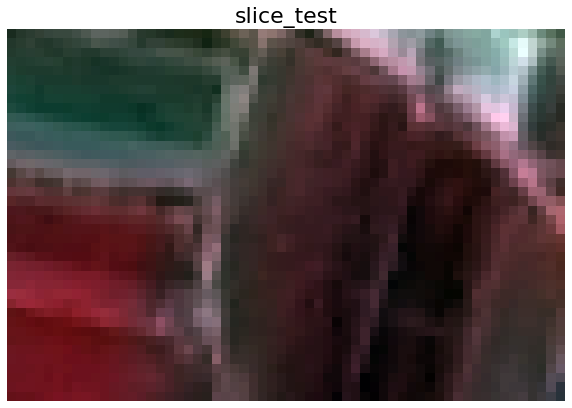

In [171]:
sliced = img[:, 10:50, 100:160]  
print(sliced.shape)
sliced.plot(bands=[3,2,1],title="slice_test")

## 3.Visualizing Imagery

geogenius 通过MatPlotLib library来实现影像的可视化，最简单的展示图像真彩色调用方法如下

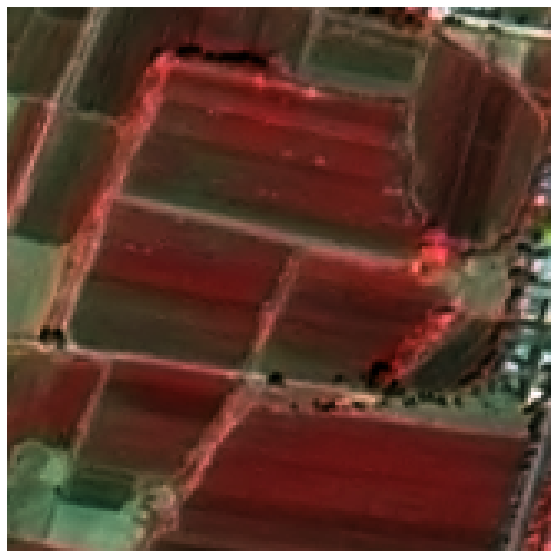

In [172]:
img.plot(bands=[3,2,1])

`plot()`方法简化了构建MatPlotLib图，并配置了合理的默认选项。如果影像只有一个波段，它将默认cmap='Grey_R'的形式展示影像。
可选的参数包括：

- w，h：绘图的宽度和高度，以72 dpi的英寸为单位。 这包括默认边框和间距。 如果图像显示在Jupyter中，则会自动裁剪外部空白以节省大小，从而产生比预期更小的图像。 默认值为`w = 10，h = 10`。  
- `bands=[3,2,1]`: 当传递三个波段的列表时，此选项对于生成伪彩色图像非常有用。 如果仅提供单个波段，则将生成灰度图。 __注意：band是一个数组，并且是从零索引的__。  
- title: 绘图的标题，如果没有指定，则不显示标题。  
- fontsize:标题的字体大小，以磅为单位。默认值为22。  
- cmap：用于单波段图像的MatPlotLib色彩映射。默认值为`cmap ='Grey_R'`。  
- histogram, stretch, and gamma:这些参数为图像的动态范围调整提供了多个选项，可将源图像转换为所需的适当范围。 如果未指定这三个选项，则默认参数为`stretch = [2,98]`。  
   
    - histogram：调整图像的直方图：  
        - `histogram ='equalize'`：对图像执行直方图均衡。
        - `histogram ='minmax'`：将像素范围拉伸到最小和最大输入像素值。 相当于拉伸= [0,100]。
        - `histogram ='match'`：将直方图与Maps API图像相匹配。 传递附加关键字blm_source ='browse'以匹配浏览服务（图像缩略图）。
        - `histogram ='ignore'`：如果图像已经正确平衡且值在正确的范围内，则跳过动态范围调整。  
    
    - stretch：在源图像动态范围的两个百分位值之间拉伸直方图。   
    - gamma：调整图像伽玛。 大于1的值将使图像中间调变亮，小于1的值将使中间调变暗。 默认值为`gamma = 1.0`。

使用“match”和“equalize”的生成的直方图可以与stretch 和gamma组合。直方图拉伸和伽玛选项将在直方图均衡化的基础上应用。

要在MatPlotLib中创建更高级的绘图，您可以创建一个NumPy数组，可以使用`image.rgb()`方法进行绘图，该方法可以反映上面列出的`plot()`的histogram, stretch, gamma和bands选项，然后使用`matplotlib.pyplot.imshow`方法将数组添加到绘图中。

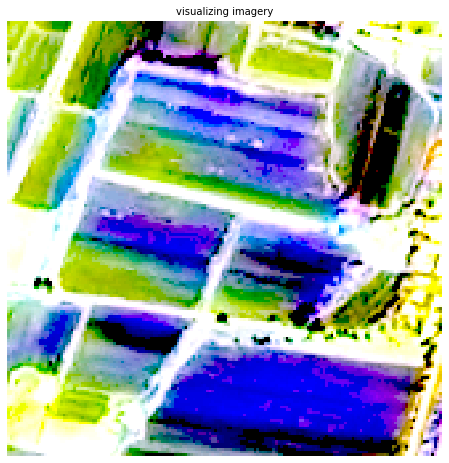

In [184]:
img.plot(bands=[0,2,3],w=8,h=8,title="visualizing imagery",fontsize=10,histgoarm="equalize",stretch=[20,80],gamma=3)

**目前为止，已经完成了导入数据，裁剪数据，对数据进行操作并且进行可视化等一系列基础但重要的操作，恭喜！  
接下来将介绍的属于高级操作，主要包括 Dask arrays 的使用，这部分可以帮助你极大提高图像处理的效率，加油。**

## 4.Mapping functions over Dask arrays

图像类的基础数据结构是Dask array，它推迟了计算操作直到需要获取对应像素。执行获取像素数据后，它返回NumPy类型的数组。Dask支持将许多标准函数，例如加法和乘法，进行排队。在像素加载已经加载后，这些排队的函数将作用在返回的图块上。  
如果有一个需要NumPy数组作为参数的自定义函数`MyFilter`，则在运行函数后会丢失图像对象的功能：   
```
from SomeImageLibrary import MyFilter
image = CatalogImage(....)
filtered = MyFilter(image.read())
filtered.geotiff() # Errors - NumPy array has no geotiff method!  
```
Dask有一个`map_blocks()`方法，可以排队任何可以操作图块的函数。geogenius重写了此方法，因此它的工作方式相同但同时返回另一个图像对象。所以不用担心操作后的图像属性丢失了：  
``` 
from SomeImageLibrary import MyFilter
image = CatalogImage(....)
filtered = image.map_blocks(MyFilter) # queue the filter to run when the data is loaded
filtered.geotiff() # Works

```
__注意：`map_blocks()`应用的函数(`MyFilter`)必须能够独立地在每个瓦片上运行，否则`map_blocks()`将无法访问其他瓦片或有关整体影像状态的其它信息
。__

## 5.Bootstrapping NumPy arrays to GeoDaskImages 

当你没有能够在图像切片上以瓦片方式运行的函数时，还有第二种方法可以保留图像对象功能。通过使用一些比较底层的图像元类，可以将NumPy数组引导回简化的图像对象：

```
# starting with a similar situation
from SomeImageLibrary import MyFilter
image = CatalogImage(...)
filtered = MyFilter(image.read()) # returns a NumPy array

# we'll also need to import
from gbdxtools.images.meta import GeoDaskImage
import dask.array as da
import numpy as np

# convert the array to a Dask array. A chunk size of 256 will work fine.
filtered_dask = da.from_array(filtered, 256)

# bootstrap a GeoDaskImage from the rgb Dask array and the original image's geo parameters
geo_filtered = GeoDaskImage(filtered_dask, __geo_interface__=image.__geo_interface__, __geo_transform__=image.__geo_transform__)

# export
geo_filtered.geotiff(path='filtered.tif')
```

##  6.Random chips

In [187]:
#todo